In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")

In [4]:
species = 'macaque'
model = 'ubbfne7l'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val1/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
# val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val3/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/log_val2/{species}_liver_VAL.narrowPeak', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# Subtract col4 values from df2 and df3
# merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# nan = res[res.isna().any(axis=1)]

# nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_VAL_TRAIN.csv', sep="\t", header=None)
mouse_real_neg=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/splits/logPos/mouse_liver_VAL.narrowPeak', sep="\t", header=None)

real_neg_len = 2*len(mouse_real_neg)
real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred[real_neg_len:real_neg_len+real_pos_len].reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

print(pearson_spearman(x, y))

# plt.figure(figsize=(8, 8))
# plt.axis([-2.5, 2.5, -2.5, 2.5])
# plt.scatter(x, y, alpha=0.2)
# plt.xlabel(f'mouse real - {species} real')
# plt.ylabel(f'mouse pred - {species} pred')
# plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
# plt.grid(True)
# plt.show()

# of same sign for true difference and predicted difference: 292 / 520 = 0.5615384615384615 %
# of same sign for true difference and averaged predicted difference: 147 / 260.0 = 0.5653846153846154%
Pearson correlation coefficient: 0.1558, p-value: 0.0003622
Spearman correlation coefficient: 0.1561, p-value: 0.0003528
None


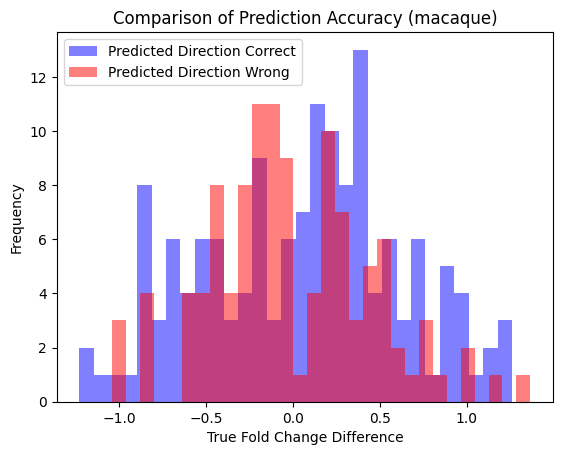

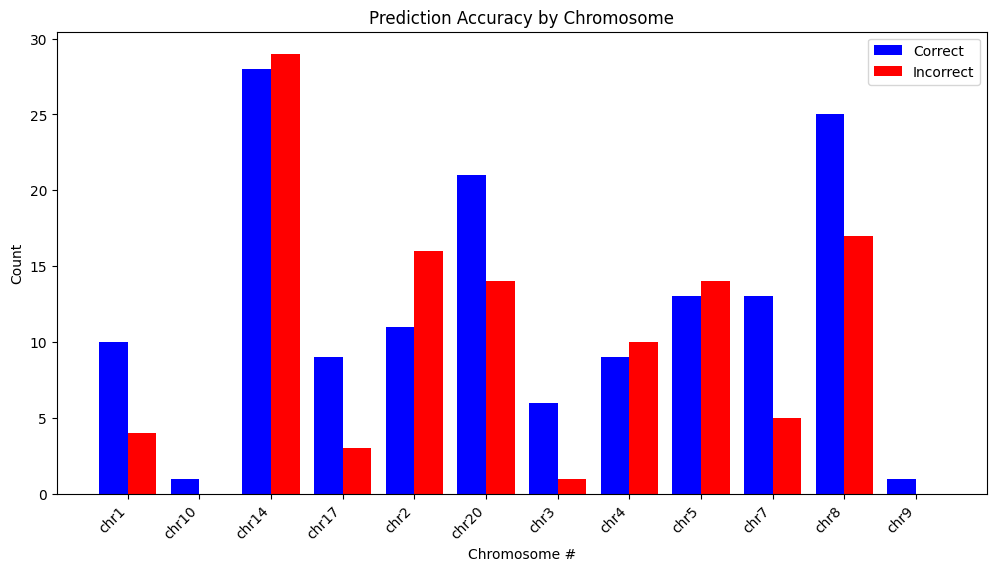

In [5]:
correct_mask = (bigboss['true'] * bigboss['avg_pred']) > 0
incorrect_mask = (bigboss['true'] * bigboss['avg_pred']) < 0

# Extract values for histogram plotting
correct_values = bigboss.loc[correct_mask, 'true']
incorrect_values = bigboss.loc[incorrect_mask, 'true']

# Plot both histograms in one figure
plt.hist(correct_values, bins=30, alpha=0.5, color='blue', label='Predicted Direction Correct')
plt.hist(incorrect_values, bins=30, alpha=0.5, color='red', label='Predicted Direction Wrong')

# Labels and title
plt.xlabel('True Fold Change Difference')
plt.ylabel('Frequency')
plt.title(f'Comparison of Prediction Accuracy ({species})')
plt.legend()  # Show legend to distinguish colors

# Show the plot
plt.show()

chr_counts = bigboss.groupby('mac_chr').agg(
    correct=('true', lambda x: (x[correct_mask]).count()),
    incorrect=('true', lambda x: (x[incorrect_mask]).count())
).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4  # Adjust width of bars
x_indexes = np.arange(len(chr_counts['mac_chr']))

# Plot bars for correct and incorrect predictions
ax.bar(x_indexes - bar_width/2, chr_counts['correct'], width=bar_width, color='blue', label='Correct')
ax.bar(x_indexes + bar_width/2, chr_counts['incorrect'], width=bar_width, color='red', label='Incorrect')

# X-axis labels and formatting
ax.set_xticks(x_indexes)
ax.set_xticklabels(chr_counts['mac_chr'], rotation=45, ha='right')

# Labels and title
plt.xlabel('Chromosome #')
plt.ylabel('Count')
plt.title('Prediction Accuracy by Chromosome')
plt.legend()

# Show plot
plt.show()

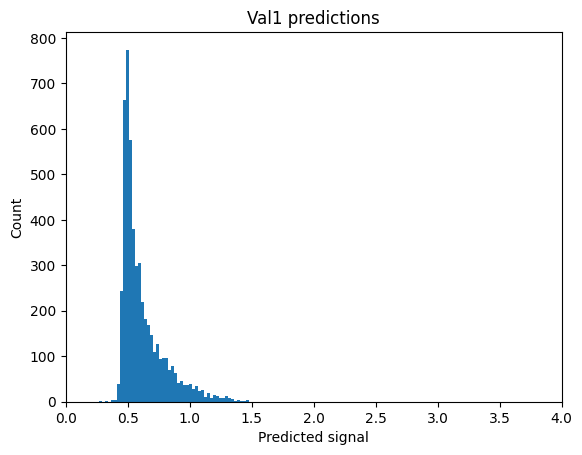

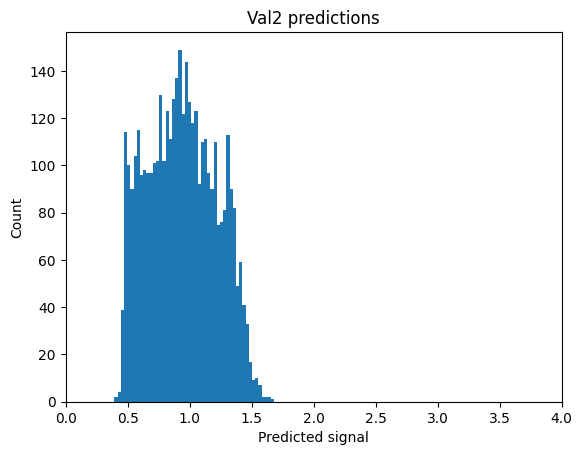

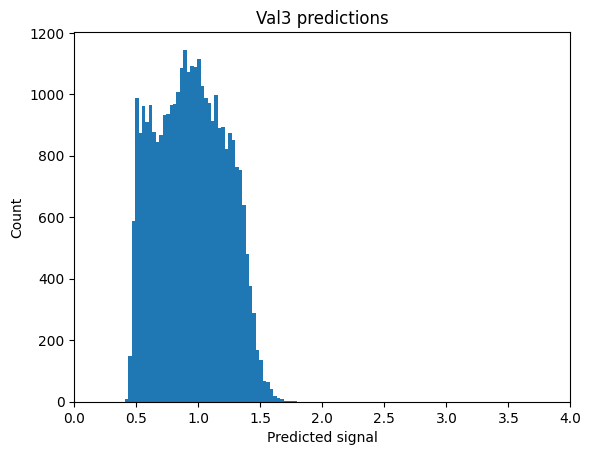

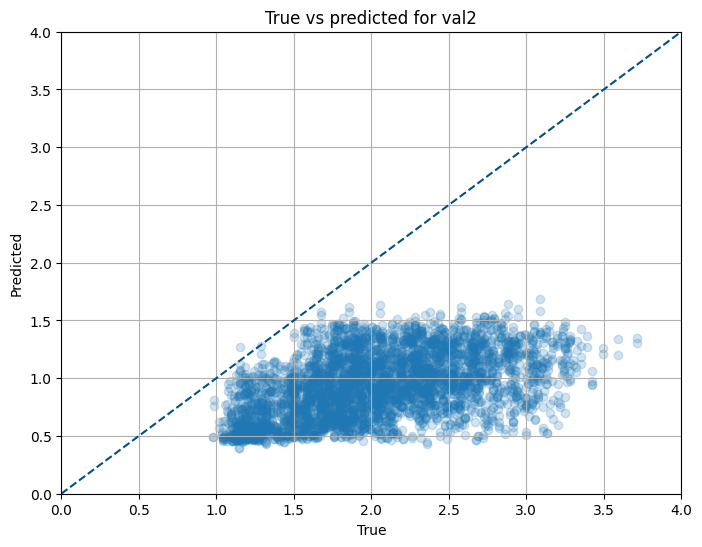

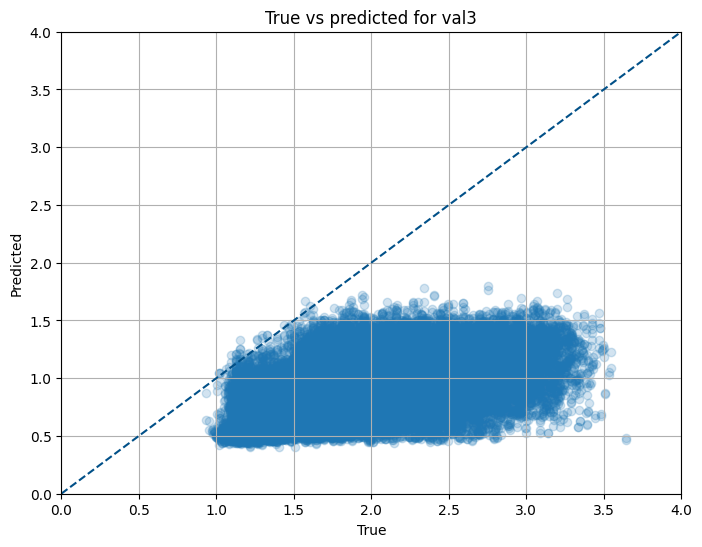

Pearson correlation coefficient for all: 0.5325, p-value: 0
Spearman correlation coefficient for all: 0.5891, p-value: 0
Pearson correlation coefficient for val2: 0.4827, p-value: 1.745e-234
Spearman correlation coefficient for val2: 0.4913, p-value: 4.294e-244
Pearson correlation coefficient for val3: 0.4937, p-value: 0
Spearman correlation coefficient for val3: 0.4982, p-value: 0


In [11]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

species='mouse'
model='bdbi7l3n'

# load all the DFs
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_VAL_TRAIN.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_2000bp.bed', header=None, delim_whitespace=True).iloc[:,4]
val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/1000Pos/mouse_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/1000Pos/mouse_liver_TRAINONLY.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)
val3_len = 2*len(val3_df)

# input sanity check
if len(pred_df) != val1_len+val2_len+val3_len:
    print("ERROR: predictions are a different length than validation sets")

doubled_val1_df = pd.concat([val1_df, val1_df]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_val3_df = pd.concat([val3_df, val3_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val1_df = pred_df.head(val1_len)
pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len]
pred_val3_df = pred_df.tail(val3_len)

doubled_combined = pd.concat([doubled_val1_df, doubled_val2_df, doubled_val3_df])

def scatter(pred_df, true_df, title, xlabel, ylabel):
    x = true_df.squeeze()
    y = pred_df.squeeze() 
    
    plt.figure(figsize=(8, 6))
    plt.xlim(0, 4)
    plt.ylim(0, 4)
    plt.plot([0, 4], [0, 4], color='#015088', linestyle='--', label='y = x')
    # plt.gcf().set_facecolor('#f3f0dfff')
    # plt.gca().set_facecolor('#f3f0dfff')
    plt.scatter(x, y, alpha=0.2)
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')
    plt.title(f'{title}')
    plt.grid(True)
    plt.show()

def plotscatter():
    # scatter(pred_val1_df, doubled_val1_df, 'True vs predicted for val1', 'True', 'Predicted')
    scatter(pred_val2_df, doubled_val2_df, 'True vs predicted for val2', 'True', 'Predicted')
    scatter(pred_val3_df, doubled_val3_df, 'True vs predicted for val3', 'True', 'Predicted')

def histogram(pred_df, title, xlabel):
    plt.hist(pred_df, bins=50) #, color='#015088'
    plt.xlim(0, 4)
    # plt.gcf().set_facecolor('#f3f0dfff')
    # plt.gca().set_facecolor('#f3f0dfff')
    plt.xlabel(f'{xlabel}')
    plt.ylabel('Count')
    plt.title(f'{title}')
    plt.show()

def ploth():
    histogram(pred_val1_df, 'Val1 predictions', 'Predicted signal')
    histogram(pred_val2_df, 'Val2 predictions', 'Predicted signal')
    histogram(pred_val3_df, 'Val3 predictions', 'Predicted signal')
    
def correlations(pred_df, true_df, group):
    x = true_df.squeeze()
    y = pred_df.squeeze()
    
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient for {group}: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")
    
    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient for {group}: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")

def correlate():
    correlations(pred_df, doubled_combined, 'all')
    correlations(pred_val2_df, doubled_val2_df, 'val2')
    correlations(pred_val3_df, doubled_val3_df, 'val3')

def wilcoxon(neg, pos):
    stat, p_value = scipy.stats.ranksums(neg, pos)
    print("Wilcoxon Rank-Sum Test:")
    print(f"Test Statistic: {stat}")
    print(f"P-value: {p_value}")
    
    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference between the two distributions (reject null hypothesis).")
    else:
        print("There is no significant difference between the two distributions (fail to reject null hypothesis).")

    
def wilcox():
    wilcoxon(pred_val1_df, pred_val2_df)
    wilcoxon(pred_val1_df, pred_val3_df)

ploth()
plotscatter()
correlate()